<a href="https://colab.research.google.com/github/hhannuniemi/street_dust_prediction/blob/master/Street_dust_prediction_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting street dust concentrations with dilated causal convolutional neural networks

## Problem and data description

A model for predicting street dust concentrations for 12 hours ahead based on 64 hours history observations is developed in this project work. Model architecture has got inspiration from adapted WaveNet network by *Borovykh et al., 2018* . Network contains stacks of dilated convolutions that allow it to access a broad range of history when forecasting, residual connections, a LeakyRELU activation function and conditioning with multivariate input data. PyTorch is used to build the model.

Street dust is a recurring problem in Finland especially in springtime because sand and other road surface material are released into the air when snow and ice have melted and streets have dried. Street dust consist of materials from street surfaces, sanding materials, and materials from brakes and studded tires. Street dust concentrations are typically higher also during end of the year when road sanding usually begins, but roads are not yet fully covered by snow and ice. Construction sites and street work also cause street dust. Most street dust particles are less than 10 micrometres (PM10) in diameter. 

Street dust can cause respiratory tract irritation causing cold-like symptoms, coughing and irritation to the eyes, nose and throat. People suffering from asthma, small children and and those suffering from the coronary artery disease are most vulnerable to adversarial effects of street dust. Weather conditions,  quality of the road surface and amount of traffic affects street dust concentration levels. Wet conditions prevent dust from street surfaces rising into the air, and gusty wind can lift street dust efficiently from unclean roads. The dustiest areas are busy streets and cross-roads during rush hours.

In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_load

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Input data is history observations of hourly PM10 concentrations, amount of rain, temperature and wind speed. Concentration data is from air quality monitoring station located at near busy street (Mäkelänkatu) in Helsinki, and weather data is from nearby weather station (Kumpula). Data is from period 01.01.2017-30.4.2019, i.e. 28 months of hourly observations. Data is downloaded from https://en.ilmatieteenlaitos.fi/download-observations#!/.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# load data
df = pd.read_csv('/content/drive/My Drive/data/PM10_weather_data_LONG2.csv',  parse_dates=[['Year', 'Month', 'Day', 'Time']])
df.tail()

,Year_Month_Day_Time,Time zone,PM10 concentration (ug/m3),Amount of rain (mm/h),Temperature (degC),Wind speed (m/s)
20395,2019-04-30 19:00:00,UTC,27.6,0.0,5.9,2.8
20396,2019-04-30 20:00:00,UTC,29.4,0.0,5.2,2.8
20397,2019-04-30 21:00:00,UTC,20.7,0.0,5.0,2.0
20398,2019-04-30 22:00:00,UTC,22.9,0.0,5.1,2.3
20399,2019-04-30 23:00:00,UTC,21.0,0.0,4.8,2.6


In [5]:
# print start and end time
# set the time as index
data_size = df.shape[0]
print("Total amount of hours:", data_size)
df.drop('Time zone', axis=1, inplace=True)
first = df['Year_Month_Day_Time'].iloc[0]
last = df['Year_Month_Day_Time'].iloc[-1]
print("Data ranges from %s to %s." % (first, last))
df = df.set_index('Year_Month_Day_Time')

Total amount of hours: 20400
Data ranges from 2017-01-01 00:00:00 to 2019-04-30 23:00:00.


PM10 concentration values varies between -5 and 280 micrograms/m^3. Negative values are probably due to some malfunction in measurement device. From the histograms at Figure 1 we can see that distributions of PM10 concentration and amount of rain are skewed. Distribution of temperature and wind speed are more closer to normal distribution. Time series of PM10 concentration and temperature are shown in Figure 2. 

In [6]:
# check min and max values for the concentration i.e. predictant
print(df['PM10 concentration (ug/m3)'].min())
print(df['PM10 concentration (ug/m3)'].max())

-5.2
281.7


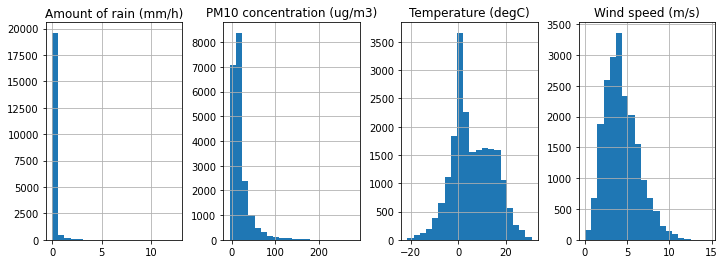

In [7]:
# plot histograms of input data
hist = df.hist(bins=20, layout=(1,4), figsize=(12,4))

Figure 1. Histograms of input data.

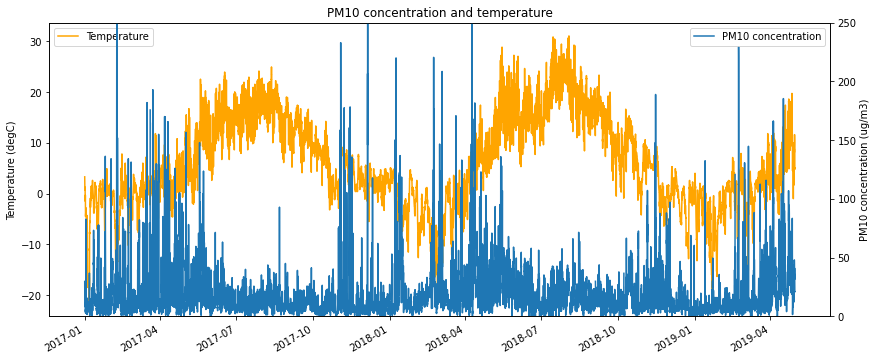

In [44]:
# plot temperature and PM10 concentration
plt.rcParams['figure.figsize']=(14,6)
fig2, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.plot(df['Temperature (degC)'], color='orange', label='Temperature')
ax2.plot(df['PM10 concentration (ug/m3)'], label='PM10 concentration')
ax1.set_ylabel('Temperature (degC)')
ax2.set_ylabel('PM10 concentration (ug/m3)')
ax2.set_ylim(0, 250)
plt.gcf().autofmt_xdate()
plt.margins(x=0,y=0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_title('PM10 concentration and temperature')
#fig2.savefig('temp_plot.png')

Figure 2. Time series of PM10 concentration and temperature.

In [ ]:
# plot wind speed and PM10 concentration
plt.rcParams['figure.figsize']=(14,6)
fig2, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.plot(df['Wind speed (m/s)'], color='orange', label='Wind speed')
ax2.plot(df['PM10 concentration (ug/m3)'], label='PM10 concentration')
ax1.set_ylabel('Wind speed (m/s)')
ax2.set_ylabel('PM10 concentration (ug/m3)')
ax2.set_ylim(0, 250)
plt.gcf().autofmt_xdate()
plt.margins(x=0,y=0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_title('PM10 concentration and wind speed')

In [ ]:
# plot amount of rain and PM10 concentration
plt.rcParams['figure.figsize']=(14,6)
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.bar(df['Amount of rain (mm/h)'].index, df['Amount of rain (mm/h)'], alpha=0.7, color='orange', label='Amount of rain')
ax2.plot(df['PM10 concentration (ug/m3)'], label='PM10 concentration')
ax1.set_ylabel('Amount of rain (mm/h)')
ax2.set_ylabel('PM10 concentration (ug/m3)')
ax2.set_ylim(0, 250)
plt.gcf().autofmt_xdate()
plt.margins(x=0,y=0)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_title('PM10 concentration and amount of rain')

## Method

The adopted dilated causal convolutional neural network stucture is based on Google's famous WaveNet model from first developed for audio forecasting (*van den Oord et al., 2016*).  The intuition behind using convolutional neural networks (CNN) for time series forecasting is that CNNs should be able to learn filters that represent certain repeating patterns in the time series, similarly as with images,  and use these to forecast the future values. With timeseries we use one dimensional convolution. Training a model on multivariate input data allows the network to exploit the correlation structure between these multiple time series and learning long-term temporal dependencies in between series . The advantage of the CNN over the recurrent-type network is that due to the convolutional structure of the network, the number of trainable weights is small, resulting in a much more efficient training and predicting *(Borovykh et al., 2018)*.

In a dilated convolution the filter is applied to every "dilation rate"th element in the input vector, allowing the model to efficiently learn connections between far-apart data points. Using the dilated convolutions instead of regular ones allows the output to be influenced by more nodes in the input i.e. expand the receptive field of the model.  The receptive field of the model is the number of neurons (time steps) in the input that can modify the output in the final layer, i.e. the forecasted time series. The receptive field depends on the number of layers L and the filter size k. In this model architecture the dilations are increasing in every layer by a factor of two: 1, 2, 4, 8, etc. The filter size (same as kernel size) is chosen to be 2 and number of layers is 6, so the receptive field of the model is 64 hours in this experiment. Figure 3 represents illustration of dilated layers.

<img src="dilate.png" width=1000 height=600 />

Figure 3. Illustration of dilation layers (from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb).

The word causal indicates that the convolution output should not depend on future inputs. In time series this is equivalent to padding the input (in the left) with a vector of zeros of the size of the receptive field. Conditioning with multiple input time series is done with separate convolutions with LeakyRELU activation function and skip connections for each input series and then concatenated together to form output from the first layer. In the first layer dilation rate is 1. The skip connections are parametrized by 1×1 convolutions, i.e. kernel size is 1, and number of output channels (filters) of 1. If some condition does not improve the forecast, the model can simply learn to discard this condition by setting the weights in the parametrized skip connection to zero. In the first layer each input time series skip connections and convolution outputs are concatenated together and then they are passed to 1×1 convolution to form the output of first layer. Subsequent layers have convolution with increasing dilation rate and LeakyRELU activation function and residual connection from input to output of the layer. Residual connection is added to the convolution output to form the final output of the layer. After the last layer there is final 1×1 convolution which outputs the forecasted time series. Only last 12 hours are taken from the final output.

Figure 4 illustrates the model architecture of Borovykh et al., 2018. In this adopted version separate skip connections and convolution outputs from the input time series are concatenated not summed. Both methods are commonly used in adding residual/skip connections to the convolution output, summing and concatenating. The concatenation was used in the hope that the information from conditioning input time series would propagate better in the network. In the model there is also an extra 1×1 convolution in the first layer before the output to decrease the number of filters after concatenation operation. Different activation functions, namely ReLU and SELU, was tried. The architecture presented here is with LeakyRELU activations. LeakyRELU was chosen in first place because it can handle also negative values and the He -initialization should work with LeakyRELU. There wasn´t clear difference in performance with these different activation functions. Number of filters were chosen to be 1 as in the original augmented wavenet paper.

<img src="Augmented_wavenet.png" width=1000 height=600 />

Figure 4. Model architecture of augmented Wavenet by Borovykh et al., 2018 (figure taken from the article).

The model blocks used in this project are described below.

In [249]:
class ConvBlock(nn.Module):
    def __init__(self, hidden_size, kernel_size, dilation_rate, bias=True):
        super(ConvBlock, self).__init__()
        self.hidden_size = hidden_size,
        self.kernel_size = kernel_size,
        self.dilation_rate = dilation_rate
          
        self.conv = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, dilation=dilation_rate)
        self.relu = nn.LeakyReLU()


    def forward(self, inputs):
        residual = inputs
        pads = (self.kernel_size[0] - 1) * self.dilation_rate
        inputs_padded = F.pad(inputs, (pads, 0))
        
        layer_out = self.relu(self.conv(inputs_padded))
        network_out = torch.add(residual, layer_out)
        return network_out


In [250]:
class DilatedConvNet(nn.Module):
    def __init__(self, n_layers, num_inputs, hidden_size, kernel_size, dilation_rate=1, bias=True):
        super(DilatedConvNet, self).__init__()
        self.n_layers = n_layers,
        self.hidden_size = hidden_size,
        self.kernel_size = kernel_size,
        self.dilation_rate = dilation_rate,
        self.num_inputs = num_inputs
        
        # first layer
        self.conv1 = nn.Conv1d(1, hidden_size, kernel_size=2, dilation=dilation_rate)
        self.relu1 = nn.LeakyReLU()
        self.skip_first = nn.Conv1d(1, hidden_size, kernel_size=1, dilation=dilation_rate)
        # decrease the number of filters after concat to hidden size
        self.conv2 = nn.Conv1d(hidden_size*2*num_inputs, hidden_size, kernel_size=1, dilation=dilation_rate)
        
        # other layers
        other_layers = [ConvBlock(hidden_size=hidden_size, kernel_size=kernel_size, dilation_rate=2 ** i) for i in range(1, n_layers)]
        self.group = nn.Sequential(*other_layers)
        
        # last layer with 1x1 convolution
        self.dense = nn.Conv1d(hidden_size, 1, kernel_size=1, dilation=dilation_rate)
        
        # initialize weights with He -initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
                

    def forward(self, inputs):
        # padding the input with a vector of zeros of the size of the receptive field
        pads = (self.kernel_size[0] - 1) * self.dilation_rate
        inputs_padded = F.pad(inputs, (pads[0], 0))

        # first layer
        input_layer = []
        for i in range(self.num_inputs):
            layer_out = self.relu1(self.conv1(inputs_padded[:,i,:].view(inputs_padded.shape[0],1,-1)))
            skip_out = self.skip_first(inputs[:,i,:].view(inputs.shape[0],1,-1))
            #out = torch.add(skip_out, layer_out)
            out = torch.cat((skip_out, layer_out), dim=1) # Which is better adding or concatenating?
            input_layer.append(out)
        out = torch.cat(input_layer, dim=1)#.sum(dim=1, keepdim=True)
        #out = torch.add(input_layer, dim=1)
        out = self.conv2(out)
        
        # other layers
        out = self.group(out.view(out.shape[0],out.shape[1],-1))
        
        # last layer
        network_out = self.dense(out)
        outputs = network_out[:,:,-output_steps:] # output only last n_out hours
        #print(f'shape of output tensor after last layer {outputs.shape}')
        return outputs

In [286]:
# model parameters for DilatedConv
n_layers = 6
hidden_size = 5
kernel_size = 2
num_inputs = 4 # number of input features
model = DilatedConvNet(n_layers=n_layers, num_inputs=num_inputs, hidden_size=hidden_size, kernel_size=kernel_size)
model.to(device)

# using mean absolute error as a criterion
criterion = nn.L1Loss()
# using Adam optimizer and L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.001)
# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

For model comparison let's make a simple two-layer ConvNet without dilation and skip connections.

In [242]:
class SimpleConv(nn.Module):
    def __init__(self, hidden_size, kernel_size, num_inputs, output_steps, bias=True):
        super(SimpleConv, self).__init__()
        self.hidden_size = hidden_size,
        self.kernel_size = kernel_size
        self.num_inputs = num_inputs
        self.output_steps = output_steps
          
        self.conv1 = nn.Conv1d(1, hidden_size*num_inputs, kernel_size=kernel_size)
        self.relu = nn.LeakyReLU()
        self.dense = nn.Linear(hidden_size*62, output_steps)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, inputs):
        inputs = inputs[:,num_inputs,:].view(inputs.shape[0],num_inputs,-1)
        out = self.relu(self.conv1(inputs))
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        out = out.view(out.size(0), 1, -1)
        return out


In [283]:
# model parameters for SimpleConv
hidden_size = 3
kernel_size = 3
num_inputs = 1
output_steps = 12
model_simple = SimpleConv(hidden_size=hidden_size, kernel_size=kernel_size, num_inputs = num_inputs, output_steps=output_steps)
model_simple.to(device)

# using mean absolute error as a criterion
criterion = nn.L1Loss()
# using Adam optimizer and L2 regularization
optimizer = optim.Adam(model_simple.parameters(), lr=0.001, weight_decay=0.001)
# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Convolutional layer weights are initialized with zero-mean Gaussian distribution and standard deviation of sqrt(2/z), where z is the total number of trainable parameters in the layer. Objective function is mean absolute error and Adam gradient descent was used with learning rate 0.001. L2 regularization, i.e. weight decay, was used to avoid overfitting with regularization rate 0.001. These parameters was chosen to be same asi in (Borovykh et al., 2018). Hyperparameter search was not done.

In the chosen model architecture the output is a vector of 12 values, i.e. the model predicts directly concentrations for the next 12 hours. The model is static, it is trained only one time. Other option could have been to implement architecture which have 12 separate models, each predicting value for certain hour. Or model wich will output only next hour, then updated with new input data, and this woul be looped over 12 iterations.

## Data preparation

There are some missing values in the data,  1% of PM10 concentration observations and less than  1% of weather observations are missing. Missing time stamps are filled using linear interpolation. The amount of missing data is small and because the causal nature of input data, the missing time stamps are decided to fill, not delete. Input data consist of 20 400 hours which is divided to training (18 000 hours) and test (2 400 hours) sets. Training data is separated to equal length sequences of training input (512 hours) and training target (48 hours) data in overlapping moving window format. Target data is non-overlapping between sequences. When the training data is splitted using overlapping moving window method there will be  35 separate sequences, i.e. samples. These are further divided to training (30 samples) and validation (5 samples ) sets. 

In [25]:
# check missing values
print("Missing values:\n")
print(df.isnull().sum(), "\n")


Missing values:

PM10 concentration (ug/m3)    258
Amount of rain (mm/h)          15
Temperature (degC)              3
Wind speed (m/s)              188
dtype: int64 



In [26]:
# use linear interpolation for filling the missing values
df_fill = df.interpolate()
print(df_fill.isnull().sum(), "\n")
# check data types
df_fill.dtypes

PM10 concentration (ug/m3)    0
Amount of rain (mm/h)         0
Temperature (degC)            0
Wind speed (m/s)              0
dtype: int64 



PM10 concentration (ug/m3)    float64
Amount of rain (mm/h)         float64
Temperature (degC)            float64
Wind speed (m/s)              float64
dtype: object

In [27]:
# split input data to train and test batches
print(df_fill.columns)
n = len(df_fill)
train = df_fill[0:int(n*0.9)].to_numpy()
test = df_fill[int(n*0.9):].to_numpy()
# check the shapes of train and test sets
# and check that last value of train data and first value of test data are different
print(train.shape)
print(test.shape)
print(train[-1,:])
print(test[0,:])

Index(['PM10 concentration (ug/m3)', 'Amount of rain (mm/h)',
       'Temperature (degC)', 'Wind speed (m/s)'],
      dtype='object')
(18360, 4)
(2040, 4)
[ 5.5  0.  -3.2  2.7]
[ 4.9  0.  -1.5  4.2]


Because the scales are different in input data, it is standardized by removing the mean and scaling to unit variance. There are lot's of zeros in one of the input time series (amount of rain), so also for this reason the scaling is needed. The scaling is done separately for each split, so that the information from training targets doesn't leak to training inputs. When the trained model is used for prediction the scaling have to be done also for the input data, and of course re-scaling before inputting the predicted values.

In [28]:
# convert training data into batches of equal length sequences of train_inputs and train_targets
# option for scaling the data is included
# modified function, original from https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/
def split_equal_sequences(data, n_input, n_out, scaling=False):
    X, y = list(), list()
    in_start = 0
    # step over the training data one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, :]
            y_input = data[in_end:out_end, 0].reshape(n_out,1)
        # standardize data by removing the mean and scaling to unit variance
            if scaling:
              scaler = StandardScaler().fit(x_input)
              scaler2 = StandardScaler().fit(x_input[:,0].reshape(-1,1))
              x_input = scaler.transform(x_input)
              y_input = scaler2.transform(y_input.reshape(-1,1))
      
            X.append(x_input)
            y.append(y_input)
		    # shift window to n_out steps forward
        in_start += n_out
        #in_start += 1 #try with overlapping moving window
    return np.array(X), np.array(y)

In [29]:
# Length of input data (hours of history data) and lenght of prediction period
input_steps = 64
output_steps = 12

In [30]:
# split training data to input and target sequences. 
train_inputs, train_targets = split_equal_sequences(train, input_steps, output_steps, scaling=True)
print(train_targets.shape)
print(train_inputs.shape)
print(train_inputs[0,:,0])


(1524, 12, 1)
(1524, 64, 4)
[ 1.18887573  0.2259088   0.00736311 -0.06093242 -0.18386436 -0.19069392
 -0.08825063 -0.265819   -0.10190973 -0.07459152 -0.1360575  -0.19752347
 -0.27264855 -0.05410286 -0.10873928 -0.19069392 -0.18386436 -0.25215989
 -0.44338737 -0.58680797 -0.55266021 -0.5390011  -0.38875095 -0.57314887
 -0.44338737 -0.58680797 -0.60729663 -0.66193305 -0.45704647  0.66982972
  1.35961455  1.42108052  2.60259314  2.3772179   3.72263978  4.80853866
  0.4717727  -0.11556884 -0.21118257 -0.19752347 -0.49802379 -0.58680797
 -0.47753513 -0.49802379 -0.43655781 -0.43655781 -0.51851245 -0.50485334
 -0.62095574 -0.69608082 -0.59363753 -0.62778529 -0.47070558 -0.53217155
 -0.33411452 -0.34094408 -0.35460318 -0.10873928 -0.34094408 -0.25215989
 -0.30679631 -0.16337571 -0.31362587 -0.11556884]


In [31]:
# reshape data to input format for convolution layer [batch, channels, steps] and tranform to tensors.
train_inputs_reshape = np.transpose(train_inputs, (0,2,1))
train_targets_reshape = np.transpose(train_targets, (0,2,1))
x = torch.tensor(train_inputs_reshape, device=device, dtype=torch.float)
y = torch.tensor(train_targets_reshape, device=device, dtype=torch.float)
print(x.size())
print(y.size())
print(x[0,0,:])
# combine tensors to dataset
dataset = torch.utils.data.TensorDataset(x, y)

torch.Size([1524, 4, 64])
torch.Size([1524, 1, 12])
tensor([ 1.1889,  0.2259,  0.0074, -0.0609, -0.1839, -0.1907, -0.0883, -0.2658,
        -0.1019, -0.0746, -0.1361, -0.1975, -0.2726, -0.0541, -0.1087, -0.1907,
        -0.1839, -0.2522, -0.4434, -0.5868, -0.5527, -0.5390, -0.3888, -0.5731,
        -0.4434, -0.5868, -0.6073, -0.6619, -0.4570,  0.6698,  1.3596,  1.4211,
         2.6026,  2.3772,  3.7226,  4.8085,  0.4718, -0.1156, -0.2112, -0.1975,
        -0.4980, -0.5868, -0.4775, -0.4980, -0.4366, -0.4366, -0.5185, -0.5049,
        -0.6210, -0.6961, -0.5936, -0.6278, -0.4707, -0.5322, -0.3341, -0.3409,
        -0.3546, -0.1087, -0.3409, -0.2522, -0.3068, -0.1634, -0.3136, -0.1156],
       device='cuda:0')


In [245]:
# divide the training dataset further to training and validation datasets.
# Train the model first with few samples to check the model ability to overfit
idx = list(range(len(dataset)))
train_idx = idx[:2]
val_idx = idx[2:4]
dataset_train = torch.utils.data.Subset(dataset, train_idx)
dataset_valid = torch.utils.data.Subset(dataset, val_idx)
print(len(dataset_train))
print(len(dataset_valid))

# load training and validation datasets to torch Dataloader format
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, pin_memory=False)
validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=1, shuffle=True, pin_memory=False)

2
2


In [252]:
# For whole training data
idx = list(range(len(dataset)))
train_idx = idx[:1200]
val_idx = idx[1200:]
dataset_train = torch.utils.data.Subset(dataset, train_idx)
dataset_valid = torch.utils.data.Subset(dataset, val_idx)
print(len(dataset_train))
print(len(dataset_valid))

1200
324


## Experiments and results

Model is run in Google Colab with GPUs. Different setups were tested with different numbers of layers, kernel size, hidden size and input time steps. Adding a dropout layer at the end of each convolutional layer was also tested. None of these different versions was remarkably better than other.

In [264]:
# load training and validation datasets to torch Dataloader format
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=20, shuffle=True, pin_memory=False)
validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=324, shuffle=True, pin_memory=False)

In [265]:
# Feed a batch of data from the training data to test the network
with torch.no_grad():
    dataiter = iter(trainloader)
    values, labels = dataiter.next()
    values = values.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', values.shape)

    #y = model_simple(values)
    y = model(values)
    print(y.shape)

Shape of the input tensor: torch.Size([20, 4, 64])
torch.Size([20, 1, 12])


In [287]:
#model_simple.to(device)
model.to(device)

DilatedConvNet(
  (conv1): Conv1d(1, 5, kernel_size=(2,), stride=(1,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (skip_first): Conv1d(1, 5, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(40, 5, kernel_size=(1,), stride=(1,))
  (group): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(5, 5, kernel_size=(2,), stride=(1,), dilation=(2,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): ConvBlock(
      (conv): Conv1d(5, 5, kernel_size=(2,), stride=(1,), dilation=(4,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): ConvBlock(
      (conv): Conv1d(5, 5, kernel_size=(2,), stride=(1,), dilation=(8,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): ConvBlock(
      (conv): Conv1d(5, 5, kernel_size=(2,), stride=(1,), dilation=(16,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (4): ConvBlock(
      (conv): Conv1d(5, 5, kernel_size=(2,), stride=(1,), dilation=(32,))
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dense): Conv1d(5, 1

In [221]:
# function for visualizing gradient flow, from Pytorch discussion forum
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001)
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [284]:
# train model and monitor training and validation error
# function modified from Pytorch tutorial: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_loss_history = []
    train_loss_history = []

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) #try gradient clipping
                        plot_grad_flow(model.named_parameters()) # plot gradient flow
                        optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if (epoch % 10) == 0:
                print('Epoch {}/{} {} loss: {:.4f}'.format(epoch, num_epochs - 1, phase, epoch_loss))
                #print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model, train_loss_history, val_loss_history

In [288]:
# put training and validation sets to one dictionary for the use of training function
dataloaders_dict = {'train' : trainloader, 'val': validloader}

Epoch 0/199 train loss: 5.2157
Epoch 0/199 val loss: 3.8626
Epoch 10/199 train loss: 1.0800
Epoch 10/199 val loss: 1.0572
Epoch 20/199 train loss: 1.0277
Epoch 20/199 val loss: 1.0107
Epoch 30/199 train loss: 1.0138
Epoch 30/199 val loss: 0.9977
Epoch 40/199 train loss: 1.0075
Epoch 40/199 val loss: 0.9940
Epoch 50/199 train loss: 1.0032
Epoch 50/199 val loss: 0.9931
Epoch 60/199 train loss: 1.0032
Epoch 60/199 val loss: 0.9931
Epoch 70/199 train loss: 1.0032
Epoch 70/199 val loss: 0.9931
Epoch 80/199 train loss: 1.0032
Epoch 80/199 val loss: 0.9931
Epoch 90/199 train loss: 1.0032
Epoch 90/199 val loss: 0.9931
Epoch 100/199 train loss: 1.0032
Epoch 100/199 val loss: 0.9931
Epoch 110/199 train loss: 1.0032
Epoch 110/199 val loss: 0.9931
Epoch 120/199 train loss: 1.0032
Epoch 120/199 val loss: 0.9931
Epoch 130/199 train loss: 1.0032
Epoch 130/199 val loss: 0.9931
Epoch 140/199 train loss: 1.0032
Epoch 140/199 val loss: 0.9931
Epoch 150/199 train loss: 1.0032
Epoch 150/199 val loss: 0.993

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


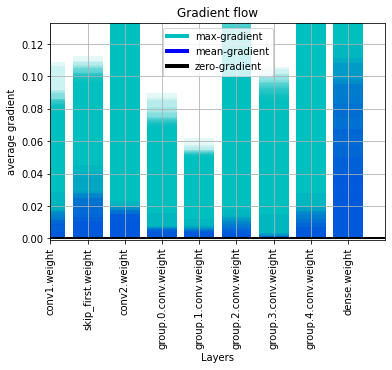

In [289]:
# train model and gather training and validation losses to list
model_trained, train_loss_history, val_loss_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=200)

In [290]:
# save model
model_filename = 'cnn_model.pth'
torch.save(model_trained.state_dict(), model_filename)

Training and validation losses are shown in Figure 5. Model underfits slightly. We tried training also with more epochs (5 000 epochs), but the validation loss started to increase slowly. We decided to cut the training in 500 epochs. For the underfitting problem solution could be to increase the input data or change the model architecture.

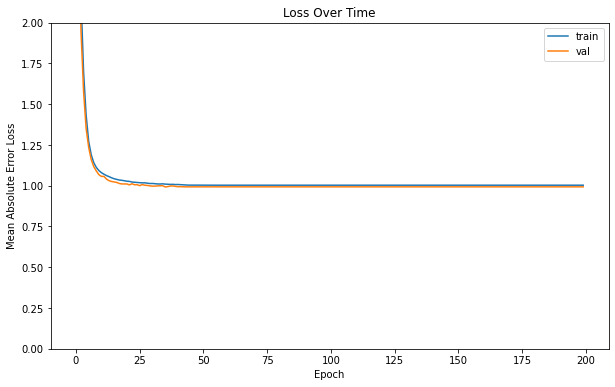

In [291]:
# plot training and validation error
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(train_loss_history)), train_loss_history, label='train')
plt.plot(np.arange(len(val_loss_history)), val_loss_history, label='val')
plt.ylim([0,2])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend()
plt.savefig('loss.png')

Figure 5. Training and validation losses.

In [292]:
model_trained.load_state_dict(torch.load(model_filename, map_location=lambda storage, loc: storage))
model_trained.to(torch.device("cpu"))
print('Model loaded from %s' % model_filename)

Model loaded from cnn_model.pth


In [293]:
# print weights of second layers convolution
print(model_trained.conv1.weight)
print(model_trained.skip_first.weight)
print(model_trained.conv2.weight)
print(model_trained.dense.weight)

Parameter containing:
tensor([[[-0.0869,  0.1034]],

        [[ 0.6977,  0.7265]],

        [[-0.0036,  1.2680]],

        [[ 0.2158, -0.3754]],

        [[ 0.2136, -1.1476]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.4344]],

        [[-1.3115]],

        [[ 0.2668]],

        [[ 1.4062]],

        [[-1.8152]]], requires_grad=True)
Parameter containing:
tensor([[[ 5.2381e-02],
         [ 2.5624e-01],
         [-3.6404e-01],
         [ 2.8746e-01],
         [ 2.6482e-01],
         [ 2.2831e-02],
         [ 3.7601e-01],
         [ 1.1458e-01],
         [-1.8526e-01],
         [-3.2753e-01],
         [ 1.4154e-01],
         [ 7.2961e-02],
         [-1.6728e-01],
         [ 1.2184e-01],
         [-2.0035e-02],
         [-1.8199e-02],
         [-3.3006e-03],
         [-1.6486e-01],
         [ 6.2881e-02],
         [-2.3721e-03],
         [ 2.4084e-01],
         [-1.7400e-02],
         [-4.1741e-02],
         [-9.9431e-02],
         [ 1.4417e-02],
         [ 6.6913e-03],
     

For the purpose of prediction first 64 hours from test data is taken as input values and the remainig test set was divided to equal lenght batches of 12 hours. There was 164 test batches. In the prediction phase input data was fed to model in iterative way. In first iteration first 64 hours from test data is fed to model and prediction is compared to the next 12 hours of test data. In the next iteration the 12 hour batch of test data is appended to input data and the prediction is done with this new input data. Mean absolute error (MAE) score is calculated to the prediction. MAE scores for each test batch are shown in Figure 6. It can bee seen that mean absolute error gets bigger when moving away from the split point of training data. In the first 10 batches MAE is less than 10, but after that is increases substantially. This is expectable because model isn't updated between iterations with new input data.

In [294]:
# function for splitting test data to non-overlapping batches of n_out hours
def split_test_data(data, n_out):
    y = list()
    in_start = 64
    for _ in range(len(data)):
        # define the end of the sequence
        in_end = in_start + n_out
        # check that we have enough data for this instance
        if in_end < len(data):
            batch = data[in_start:in_end]
            y.append(batch)
            in_start += n_out
    
    y = np.array(y)       
    y = np.transpose(y, (0,2,1))
    return y

In [295]:
# split test data to batches of n_out hours
# and reshape test data to [batches, channels, nsteps]
test_batches = split_test_data(test, output_steps)
print(test.shape)
print(test_batches.shape)

(2040, 4)
(164, 4, 12)


In [296]:
# function for predicting next n_out hours values based on "n_input" previous time steps using the trained model
def predict(model, input_data, n_input, device):
    # retrieve last observations for input data
    # last observations from input data have not been used in training
    # inputs = input_data[-n_input:, :]
    inputs = input_data[:n_input,:]
    # Standardize input data
    scaler = StandardScaler().fit(inputs)
    scaler2 = StandardScaler().fit(inputs[:,0].reshape(-1,1))
    inputs_scaled = scaler.transform(inputs)
    # reshape into [1, channels, n_input]
    inputs_reshaped = inputs_scaled.reshape(1, inputs_scaled.shape[1], inputs_scaled.shape[0])
    inputs = torch.tensor(inputs_reshaped, device=device, dtype=torch.float)
    # forecast the next n_out hours
    model.eval()
    model.to(device)
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model.forward(inputs)
        outputs = outputs.cpu().data.numpy()
        # scale back to original form and reshape output to [batch, channel, nsteps]
        outputs_rescaled = scaler2.inverse_transform(outputs.reshape(outputs.shape[2],outputs.shape[1]))
        outputs_reshaped = outputs_rescaled.reshape(1, outputs_rescaled.shape[1], outputs_rescaled.shape[0])
    return outputs_reshaped

In [297]:
def evaluate_predictions(actual, predicted):
    scores = list()
    # calculate mean absolute error (MAE) score for each n_out hour prediction period
    for i in range(actual.shape[0]):
        # calculate MAE
        mae = mean_absolute_error(actual[i,0], predicted[i,0].squeeze())
        # store
        scores.append(mae)
        # calculate average MAE
        mae_average = sum(scores) / len(scores)
    return mae_average, np.array(scores)

In [298]:
# evaluate model predictions using walk-forward validation
# test data is divided to batches of n_out hours and for each batch MAE value is calculated
def evaluate_model(model, input_data, test_batches, n_input, device):
    # walk-forward validation over each batch
    predictions = list()
    for i in range(len(test_batches)):
        # predict the n_out hours
        yhat = predict(model, input_data, n_input, device)
        # store the predictions
        predictions.append(yhat)
        # get real observation from the test data and add to input_data for predicting the next n_out hours
        test_reshaped = test_batches[i, :, :].reshape(test_batches.shape[2], test_batches.shape[1])
        input_data = np.concatenate((input_data, test_reshaped), axis=0)
        #print(f'Shape of concaneted input data {input_data.shape}')
    # evaluate predictions for each batch
    predictions = np.array(predictions)
    pred_squeezed = np.squeeze(predictions, axis=1)
    mae_average, scores = evaluate_predictions(test_batches, pred_squeezed)
    return mae_average, scores, pred_squeezed

In [299]:
# calculate MAE values for the mode predictions
mae_average, mae_scores, predictions = evaluate_model(model_trained, test, test_batches, input_steps, device)
# MAE for the first 10 batches
mae_average_10batch = sum(mae_scores[:10]) / len(mae_scores[:10])
print(mae_average_10batch)
print(mae_average)
print(predictions.shape)

4.55392950852712
17.736060184385714
(164, 1, 12)


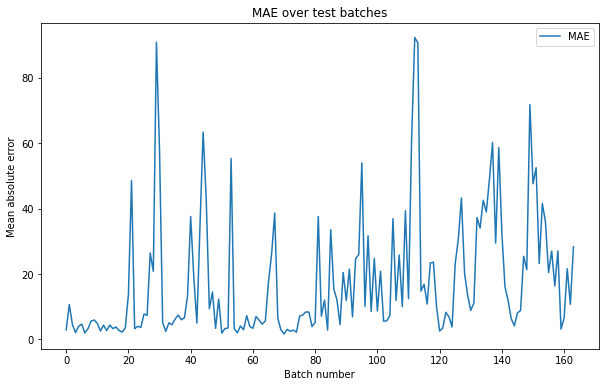

In [300]:
# plot the MAE over different test batches
plt.figure(figsize=(10,6))
plt.plot(range(len(mae_scores)), mae_scores)
plt.title('MAE over test batches')
plt.legend(['MAE'])
plt.xlabel('Batch number')
plt.ylabel('Mean absolute error')
plt.savefig('MAE_batches.png')

In the Figure 7 there are shown plots of input data, true target data and predictions for the first test batches. It's obvious that the model performace is not very good. The model doesn't capture the high concentration peaks, neither the shape of the variation. We tried also with bigger number of filters but that resulted even worse predictions with huge variation. Model predictions are compared to naive forecast, i.e. last 48 hours are used as a  prediction for next 48 hours. The MAE score of naive prediction is 17.86. Model outperfoms the naive forecast.

In [301]:
# function for plotting predictions and true observations to same figure
# figure is created per test batch
# modified function, original from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb
def plot_predictions(input_data, target_data, predictions, batch_ind, train_tail_len):
    input_series = input_data[:,0]
    pred_series = predictions[batch_ind,0,:]
    target_series = target_data[batch_ind,0,:]
      
    input_series_tail = np.concatenate((input_series[-train_tail_len:],target_series[:1]), axis=0) 
    print(f'Shape of input_series_tail {input_series_tail.shape}')
    x = input_series_tail.shape[0]
    pred_steps = pred_series.shape[0]
      
    plt.figure(figsize=(10,6))   
      
    plt.plot(range(1,x+1),input_series_tail)
    plt.plot(range(x,x+pred_steps),target_series,color='orange')
    plt.plot(range(x,x+pred_steps),pred_series,color='teal',linestyle='--')
      
    plt.title('Batch index %d' % batch_ind)
    plt.legend(['Input data','Target series','Predictions'])
    plt.xlabel('Hours')
    plt.ylabel('PM10 concentrations [micro g/m³]')

In [302]:
pred_series = predictions[0,0,:]
target_series = test_batches[0,0,:]
print(pred_series.shape)
print(target_series[:1])

(12,)
[12.1]


Shape of input_series_tail (65,)


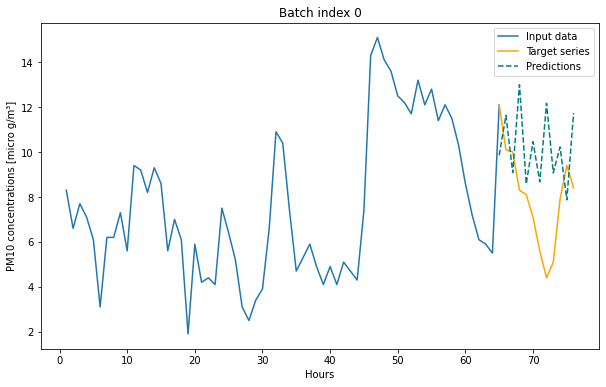

In [303]:
plot_predictions(train, test_batches, predictions, batch_ind=0, train_tail_len=64)
plt.savefig('forecast0.png')

Shape of input_series_tail (65,)


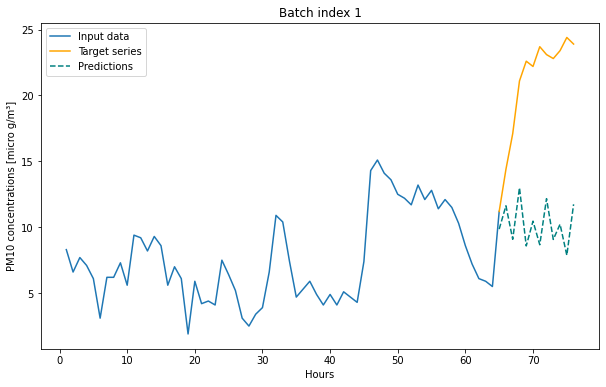

In [304]:
plot_predictions(train, test_batches, predictions, batch_ind=1, train_tail_len=64)
plt.savefig('forecast1.png')

Shape of input_series_tail (65,)


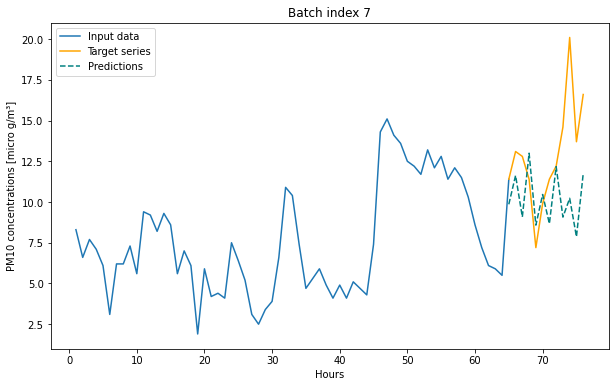

In [305]:
plot_predictions(train, test_batches, predictions, batch_ind=7, train_tail_len=64)
plt.savefig('forecast2.png')

In [306]:
# make naive forecast by taking last n_out hours as the prediction for next n_out hours and calculate MAE
def evaluate_naive(input_data, test, n_input, n_out):
    value = input_data[:n_input, 0]
    predictions = list()
    for i in range(len(test)):
        # take last n_out hours from test data
        value = input_data[-n_out:, 0]
        predictions.append(value)
        # get real observation from test data and add to input_data
        input_data = np.concatenate((value, test[i, 0, :]), axis=0).reshape(-1,1)
    # evaluate predictions for each test batches
    predictions = np.array(predictions)
    predictions = predictions.reshape(predictions.shape[0],1,predictions.shape[1])
    mae_average, scores = evaluate_predictions(test, predictions)
    return mae_average, scores

In [307]:
# calculate MAE values for the naive forecast
naive_mae_average, naive_mae_batches = evaluate_naive(test, test_batches, input_steps, output_steps)
print(naive_mae_average)

19.923323170731713


## 4. Conclusions

A model for predicting street dust concentrations for 12 hours ahead using past 64 hours observations was developed. Model is implemented with Pytorch. Model architecture contains stacks of dilated convolutions, residual connections, a LeakyRELU activation function and conditioning with multivariate input data.  Input data is hourly observations of PM10 concentrations, amount of rain, temperature and wind speed of 28 months. Input data divided into training, validation and test sets with moving window method, and scaled to zero mean and unit variance before feeding to model. Model outputs directly the 12 hours forecast, and the same model is used for making the predictions for all the test batches.

The average MAE of the model for all the test batches is 17.7 and for the first 10 batches 4.6. The MAE score of naive prediction is 19.9. Model outperfoms the naive forecast, but the prediction results are not good. The model doesn't capture the high variance of concentration curve. The training and validation losses indicates that the model is underfitting slightly. Adding more filters to the conv layers could increase the model performance.  Also adding hourly traffic amount as a conditioning data could affect positively to the model performance.

## References


A. Borovykh, S. Bohte, and C. W. Oosterlee, Conditional Time Series Forecasting with Convolutional Neural Networks, ArXiv e-prints, (2018)

A. van den Oord, S. Dieleman, H. Zen, K. Simonyan, O. Vinyals, A. Graves, N. Kalchbrenner, A. Senior, and K. Kavukcuoglu, WaveNet: A Generative Model for Raw Audio, ArXiv e-prints, (2016)

https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb